In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Categorical
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy import signal
from torch.utils.tensorboard import SummaryWriter

In [2]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/Trading_bot')

In [3]:
goog = pd.read_csv('GOOG.csv')

In [4]:
goog

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-08-12,242.212219,247.622620,241.496490,246.251251,246.251251,4404700
1,2010-08-13,244.744751,245.840836,243.248245,243.418411,243.418411,3865500
2,2010-08-16,242.082077,245.180176,240.490494,243.038040,243.038040,2607300
3,2010-08-17,244.509506,247.597595,243.258255,245.505508,245.505508,3777600
4,2010-08-18,245.465469,245.680679,241.016022,241.316315,241.316315,5367400
...,...,...,...,...,...,...,...
1756,2017-08-03,949.099976,950.000000,939.440002,940.299988,940.299988,1123900
1757,2017-08-04,943.950012,947.539978,939.799988,945.789978,945.789978,1254600
1758,2017-08-07,947.520020,948.960022,943.500000,945.750000,945.750000,1445800
1759,2017-08-08,944.289978,952.489990,942.479980,944.190002,944.190002,1505100


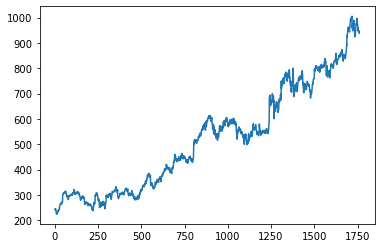

In [5]:
plt.plot(range(0, len(goog.Open)), goog.Open)

In [6]:
goog_open_orig= goog["Open"].values
goog_close_orig = goog["Close"].values

In [7]:
#Detrend data so that the bot learns to make right decision, otherwise the general trend would lead to buying on holding on to stock till end
goog_open = signal.detrend(goog_open_orig)
goog_close = signal.detrend(goog_close_orig)

In [8]:
print(goog_open.min())
print(goog_close.min())

-118.14449723337998
-119.3110126331245


In [9]:
#Shift signal to positive
goog_open += 120.
goog_close += 120.

In [10]:
print(goog_open.max())
print(goog_close.max())

273.70594141103106
273.8689523519606


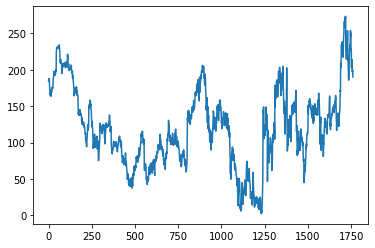

In [11]:
plt.plot(range(0,len(goog_open)), goog_open)

In [12]:
class TradingEnvironment():
    def __init__(self, data_open = goog_open, data_close = goog_close, max_stride=5, series_length=200, starting_point=0):
        
        self.data_open = data_open
        self.data_close = data_close
        #Observation space [No.of shares, Cash in hand, next opening price, portfolio value, past 5 day average]
        self.state = torch.FloatTensor(torch.zeros(5))
        #Starting cash
        self.starting_cash = 6000
        #Length of time series
        self.series_length = series_length
        self.starting_point = starting_point
        self.cur_timestep = self.starting_point
        #Initial No.of shares
        self.state[0] = 20
        #Starting portfolio value
        self.starting_portfolio_value = self.portfolio_value()
        self.state[1] = self.starting_cash
        self.state[2] = self.data_open[self.cur_timestep]
        self.state[3] = self.starting_portfolio_value
        self.state[4] = self.five_day_window()
        #Inventory holds the price of bought stock
        self.inventory = []
        num = int(self.state[0].item())
        #Append current price for the initial stocks
        for i in range(num):
            self.inventory.append(self.data_open[self.cur_timestep])

        self.stride = max_stride # no longer varying it
        self.done = False
        self.profit = 0
        
    def portfolio_value(self):#To calculate total portfolio value
        return (self.state[0] * self.data_close[self.cur_timestep]) + self.state[1]
    
    def next_opening_price(self):#Finding the next opening price
        step = self.cur_timestep + self.stride
        return self.data_open[step]
    
    def five_day_window(self):#past Five day average calc
        step = self.cur_timestep
        if step < 5:
            return self.data_open[0]
        goog5 = self.data_open[step-5:step].mean()
        return goog5
    
    def step(self, action):
        delta = 0
        action = [action, 1.]
        cur_timestep = self.cur_timestep
        cur_ts = (cur_timestep / self.stride - self.starting_point)
        retval = None
        cur_value = self.portfolio_value()
        
        #Check if done
        if cur_timestep >= self.starting_point + (self.series_length * self.stride):
            new_state = [self.state[0], self.state[1],self.next_opening_price(), cur_value, self.five_day_window()]
            self.state = new_state
            if self.profit > 0:
                rew = 1
            else:
                rew = 0
            return new_state, rew, True, { "msg": "done"}
        #action ==2 ,Do nothing return the next state
        if action[0] == 2:
            new_state = [self.state[0], self.state[1],self.next_opening_price(), cur_value, self.five_day_window()]
            self.state = new_state
            retval = new_state, 0, False, { "msg": "nothing" }
             
        #Action = 0, Buy, if there is enough cash in hand, and reward is 1 if bought for lower price than previous buy, else reward is 0    
        if action[0] == 0:
            if action[1] * self.data_open[cur_timestep] < self.state[1]:
                goog_shares = self.state[0] + action[1]
                cash_spent = action[1] * self.data_open[cur_timestep]
                new_state = [goog_shares, self.state[1]- cash_spent, self.next_opening_price(), cur_value, self.five_day_window()]
                self.state = new_state
                prev_price = self.inventory[-1]
                delt = prev_price - self.data_open[cur_timestep]
                self.state = new_state
                if delt > 0:
                    rew = 1
                else:
                    rew = 0
                self.inventory.append(self.data_open[self.cur_timestep])
                retval = new_state, rew, False, { "msg": "bought goog"}
            else:#If there is no enough cash in hand, end episode
                new_state = [self.state[0], self.state[1],self.next_opening_price(), cur_value, self.five_day_window()]
                self.state = new_state
                retval = new_state, 0, True, { "msg": "Bankrupt"}
                
        if action[0] == 1: #Action = 1, Sell, if there is enough stock, and reward is 1 if sold for higher price than bought, else reward is 0    
            if action[1] < self.state[0]:
                goog_shares = self.state[0] - action[1]
                cash_gained = action[1] * self.data_open[cur_timestep]
                new_state = [goog_shares, self.state[1] + cash_gained, self.next_opening_price(), cur_value, self.five_day_window()]
                bought_price = self.inventory.pop(0)
                delta = self.data_open[cur_timestep] - bought_price
                self.state = new_state
                if delta > 0:
                    rew = 1
                else:
                    rew = 0
                retval = new_state, rew, False, { "msg": "sold goog"}  
            else:#End episode if selling more than have
                new_state = [self.state[0], self.state[1],self.next_opening_price(), cur_value, self.five_day_window()]
                self.state = new_state
                retval = new_state, 0, True, { "msg": "Sold more than have"}
        #Calculate selling profit      
        self.profit += delta
        #Increase step
        self.cur_timestep += self.stride
        return retval
    
    def reset(self):#Reset observation space and timestep
        self.state = torch.FloatTensor(torch.zeros(5))
        self.starting_cash = 6000
        self.cur_timestep = self.starting_point
        self.state[0] = 20
        self.state[1] = self.starting_cash
        self.state[2] = self.data_open[self.cur_timestep]
        self.starting_portfolio_value = self.portfolio_value()
        self.state[3] = self.starting_portfolio_value
        self.state[4] = self.five_day_window()
        self.done = False
        self.inventory = []
        num = int(self.state[0].item())
        for i in range(num):
            self.inventory.append(self.data_open[self.cur_timestep])
        self.profit = 0

        return self.state

In [13]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.input_layer = nn.Linear(5, 128)
        self.hidden_1 = nn.Linear(128, 32)
        self.hidden_2 = nn.Linear(32,31)
        #Actor Layer
        self.action_head = nn.Linear(31, 3)
        #Critic Layer
        self.value_head = nn.Linear(31, 1)
        self.saved_actions = []
        self.rewards = []
        
    def forward(self, x):
        x = torch.tensor(x)
        x = torch.sigmoid(self.input_layer(x))
        x = torch.tanh(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values
    
    def act(self, state):
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        #Get an action
        action = m.sample()
        #If action is sell and no.of share is zero, force it to do nothing
        if action == 1 and env.state[0] < 1: action = torch.LongTensor([2]).squeeze()
        self.saved_actions.append((m.log_prob(action), state_value))
        return action.item()

In [14]:
#Define Environment, Agent, optimizer
env = TradingEnvironment(data_open = goog_open, data_close = goog_close, max_stride=1, series_length= len(goog_open)-2)
model = Policy()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [15]:
env.reset()
gamma = 0.988
#Log every 50 episode
log_interval = 50

#At the end of each episode update gardients
def finish_episode(episode):
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    returns = []
    #Calculate discounted reward
    for r in model.rewards[::-1]:
        R = r + (gamma * R)
        returns.insert(0, R)
        
    returns = torch.tensor(returns)
    
    #Standardize the discounted reward (Helps converge faster)
    eps = np.finfo(np.float32).eps.item()
    returns = (returns - returns.mean()) / (returns.std() + eps)
    #Calculate policy and value loss  
    for (log_prob, value), R in zip(saved_actions, returns):
        #Calculate advantage value
        advantage = torch.tensor(R - value.item())
        policy_losses.append(-log_prob * advantage)
        #Smooth L1 loss has the advantage of both L1 and L2 loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    #Reset gradients           
    optimizer.zero_grad()
    #Sum up policy and value losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    writer.add_scalar('Policy loss',torch.stack(policy_losses).sum(), episode)
    writer.add_scalar('Value loss',torch.stack(value_losses).sum(), episode)
    writer.add_scalar('Total loss',loss, episode)
    #Backpropogation
    loss.backward()
    optimizer.step()    
    #Delete saved rewards and actions
    del model.rewards[:]
    del model.saved_actions[:]

In [16]:
#Start training
running_reward = 0
#Train for 1000 episodes
for episode in range(0,2000):
    state = env.reset()
    done = False
    msg = None
    ep_rew = 0
    while not done:
        action = model.act(state)
        state, reward, done, msg = env.step(action)
        #print(action,state,reward)
        model.rewards.append(reward)
        ep_rew += reward
        if done:
            break
    finish_episode(episode)
    running_reward = running_reward * (1 - 0.05) + ep_rew * (0.05)
     # ...log the running reward
    writer.add_scalar('Running reward',running_reward,episode)
    #stop training if the threshold is reached
    if msg["msg"] == "done" and env.portfolio_value() > env.starting_portfolio_value * 1.1 and reward == 1 and running_reward > 900:
        print("Early Stopping--- Profit :" + str(int(env.profit)))
        break
    #Log every 10 episodes
    if episode % log_interval == 0:
        print("""Episode {}: started at {:.1f}, finished at {:.1f} because {} @ t={}, last reward {} \
episode reward {:.1f}, running reward {:.1f}""".format(episode, env.starting_portfolio_value, \
              env.portfolio_value(), msg["msg"], env.cur_timestep, reward, ep_rew, running_reward))

C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 0: started at 9794.5, finished at 9882.1 because Sold more than have @ t=974, last reward 0 episode reward 328.0, running reward 16.4
Episode 50: started at 9794.5, finished at 15157.8 because done @ t=1759, last reward 1 episode reward 650.0, running reward 366.8
Episode 100: started at 9794.5, finished at 15830.7 because done @ t=1759, last reward 1 episode reward 692.0, running reward 343.6
Episode 150: started at 9794.5, finished at 10527.7 because Bankrupt @ t=103, last reward 0 episode reward 39.0, running reward 423.7
Episode 200: started at 9794.5, finished at 14797.1 because Bankrupt @ t=1698, last reward 0 episode reward 641.0, running reward 436.3
Episode 250: started at 9794.5, finished at 6720.5 because Bankrupt @ t=1278, last reward 0 episode reward 459.0, running reward 597.2
Episode 300: started at 9794.5, finished at 11397.2 because done @ t=1759, last reward 1 episode reward 730.0, running reward 683.4
Episode 350: started at 9794.5, finished at 11564.9 becaus

In [17]:
#Check out a sample run
env.reset()
print("starting portfolio value {}".format(env.portfolio_value()))
for i in range(0,env.series_length + 1):
    action = model.act(env.state)
    next_state, reward, done, msg = env.step(action)
    if msg["msg"] == 'bankrupted self':
        print('bankrupted self by 1')
        break
    if msg["msg"] == 'sold more than have':
        print('sold more than have by 1')
        break
    print("{}, have {} shares, cash in hand is {} ".format(msg["msg"], next_state[0], next_state[1]))
    if msg["msg"] == "done":
        print("total portfolio value {}".format(env.portfolio_value()))
        break

starting portfolio value 9794.494140625
bought goog, have 21.0 shares, cash in hand is 5814.40283203125 
bought goog, have 22.0 shares, cash in hand is 5626.666015625 
sold goog, have 21.0 shares, cash in hand is 5811.34716796875 
bought goog, have 22.0 shares, cash in hand is 5624.6318359375 
bought goog, have 23.0 shares, cash in hand is 5437.353515625 
bought goog, have 24.0 shares, cash in hand is 5255.18798828125 
bought goog, have 25.0 shares, cash in hand is 5079.94189453125 
bought goog, have 26.0 shares, cash in hand is 4908.3271484375 
bought goog, have 27.0 shares, cash in hand is 4739.00732421875 
sold goog, have 26.0 shares, cash in hand is 4904.08056640625 
bought goog, have 27.0 shares, cash in hand is 4736.36767578125 
sold goog, have 26.0 shares, cash in hand is 4901.93603515625 
sold goog, have 25.0 shares, cash in hand is 5070.40966796875 
bought goog, have 26.0 shares, cash in hand is 4906.853515625 
sold goog, have 25.0 shares, cash in hand is 5072.4541015625 
boug

C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app



bought goog, have 29.0 shares, cash in hand is 4286.994140625 
bought goog, have 30.0 shares, cash in hand is 4075.281982421875 
bought goog, have 31.0 shares, cash in hand is 3865.154052734375 
sold goog, have 30.0 shares, cash in hand is 4075.104248046875 
bought goog, have 31.0 shares, cash in hand is 3861.212646484375 
sold goog, have 30.0 shares, cash in hand is 4082.749267578125 
sold goog, have 29.0 shares, cash in hand is 4298.9326171875 
sold goog, have 28.0 shares, cash in hand is 4518.412109375 
sold goog, have 27.0 shares, cash in hand is 4721.4775390625 
bought goog, have 28.0 shares, cash in hand is 4518.48974609375 
bought goog, have 29.0 shares, cash in hand is 4309.82421875 
bought goog, have 30.0 shares, cash in hand is 4102.77294921875 
bought goog, have 31.0 shares, cash in hand is 3895.52392578125 
sold goog, have 30.0 shares, cash in hand is 4094.63720703125 
bought goog, have 31.0 shares, cash in hand is 3895.471435546875 
bought goog, have 32.0 shares, cash in 

#### Testing on Google_2019 dataset

In [18]:
#Load test dataset
te_goog = pd.read_csv('GOOG_2019.csv')

In [19]:
te_goog.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,1016.570007,1052.319946,1015.710022,1045.849976,1045.849976,1532600
1,2019-01-03,1041.000000,1056.979980,1014.070007,1016.059998,1016.059998,1841100
2,2019-01-04,1032.589966,1070.839966,1027.417969,1070.709961,1070.709961,2093900
3,2019-01-07,1071.500000,1074.000000,1054.760010,1068.390015,1068.390015,1981900
4,2019-01-08,1076.109985,1084.560059,1060.530029,1076.280029,1076.280029,1764900


In [20]:
te_goog.Date = pd.to_datetime(te_goog.Date)

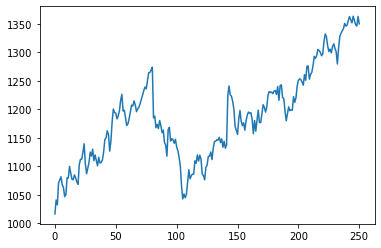

In [21]:
plt.plot(range(0,len( te_goog.Open)),  te_goog.Open)

In [28]:
env_test = TradingEnvironment(data_open=te_goog.Open, data_close = te_goog.Close, max_stride=1, series_length=len(te_goog.Close)-2)
env_test.reset()
state = env_test.reset()
reward = 0
done = False
msg = None
bought_goog_at = []
sold_goog_at = []
bg_action_times = []
sg_action_times = []
n_action_times = []
nothing_at = []
print('Starting Portfolio value :',env_test.portfolio_value().item())
while not done:
    action = model.act(state)
    if action == 0:
        bought_goog_at.append(te_goog.Open[env_test.cur_timestep])
        bg_action_times.append(env_test.cur_timestep)
    if action == 1:
        sold_goog_at.append(te_goog.Open[env_test.cur_timestep])
        sg_action_times.append(env_test.cur_timestep)
    if action == 2:
        nothing_at.append(1000)
        n_action_times.append(env_test.cur_timestep)
    state, reward, done, msg = env_test.step(action)
    model.rewards.append(reward)
if msg["msg"] == "done":
        print("Have {} shares and ${} cash. selling profit: {}, Total portfolio value: {}".format(state[0], state[1],env_test.profit, env_test.portfolio_value()))
    

Starting Portfolio value : 26917.0


C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:15: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Have 15.0 shares and $11098.4951171875 cash. selling profit: 4714.795109999999, Total portfolio value: 31376.84375


In [26]:
buy_date = [te_goog.Date[x] for x in bg_action_times]
sell_date = [te_goog.Date[x] for x in sg_action_times]

In [27]:
# Using plotly.express
import plotly.express as px
import plotly.graph_objects as go
fig = px.line(te_goog, x='Date', y='Open')
fig.add_trace(go.Scatter(x = buy_date,y = bought_goog_at, mode="markers",showlegend=True,name="Buy"))
fig.add_trace(go.Scatter(x = sell_date,y = sold_goog_at, mode="markers",showlegend=True,name="Sell"))
fig.update_xaxes(rangeslider_visible=True)
fig.show()